In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


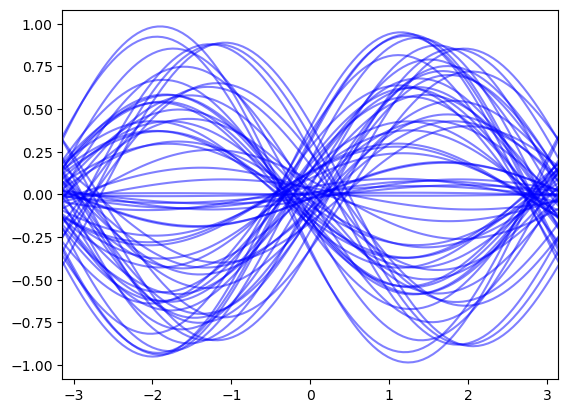

In [5]:
from data.datasets import SineData
from math import pi

# Create dataset
dataset = SineData(amplitude_range=(-1., 1.),
                   shift_range=(-.5, .5),
                   num_samples=2000)

# Visualize data samples
for i in range(64):
    x, y = dataset[i] 
    plt.plot(x.numpy(), y.numpy(), c='b', alpha=0.5)
    plt.xlim(-pi, pi)

In [13]:
from src.attnp import AttentiveNeuralProcess

x_dim = 1
y_dim = 1
r_dim = 64  # Dimension of representation of context points
z_dim = 64  # Dimension of sampled latent variable
h_dim = 64  # Dimension of hidden layers in encoder and decoder

anp = AttentiveNeuralProcess(x_dim=x_dim,
                             y_dim=y_dim,
                             r_dim=r_dim,
                             z_dim=z_dim,
                             embed_dim=h_dim,
                             h_dim=h_dim,
                             ).to(device)
print(sum(p.numel() for p in anp.parameters() if p.requires_grad))

113026


In [10]:
print(anp)

AttentiveNeuralProcess(
  (determinisitic_values): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=64, bias=True)
    (13): Identity()
  )
  (deterministic_qks): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Identity()
  )
  (cross_attention): CrossAttention(
    (q_proj): Linear(in_features=64, out_features=64, bias=True)
    (k_proj): Linear(i

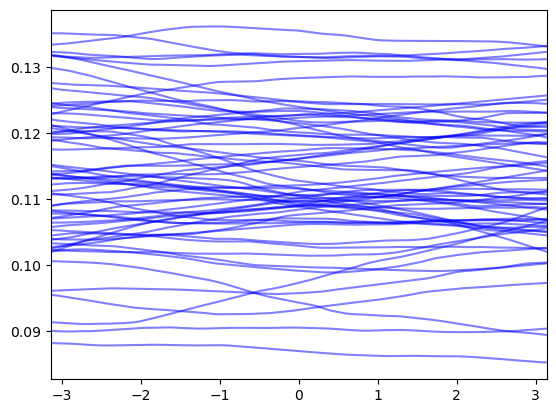

In [15]:
# Create a set of 100 target points, with shape 
# (batch_size, num_points, x_dim), which in this case is
# (1, 100, 1)
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))  # Shape (batch_size, z_dim)
    # Map x_target and z to p_y_target (which is parameterized by a 
    # normal with mean mu and std dev sigma)
    py = anp.decoder(x_target.to(device), z_sample.to(device))
    mu = py.mean
    # Plot predicted mean at each target point (note we could also
    # sample from distribution but plot mean for simplicity)
    plt.plot(x_target.cpu().numpy()[0], mu.cpu().detach().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-pi, pi)

In [25]:
from torch.utils.data import DataLoader
from torch.distributions.kl import kl_divergence
from src.utils import context_target_split
from random import randint

def _loss(p_y_pred, y_target, q_target, q_context):
        """
        Computes Neural Process loss.

        Parameters
        ----------
        p_y_pred : one of torch.distributions.Distribution
            Distribution over y output by Neural Process.

        y_target : torch.Tensor
            Shape (batch_size, num_target, y_dim)

        q_target : one of torch.distributions.Distribution
            Latent distribution for target points.

        q_context : one of torch.distributions.Distribution
            Latent distribution for context points.
        """
        # Log likelihood has shape (batch_size, num_target, y_dim). Take mean
        # over batch and sum over number of targets and dimensions of y
        log_likelihood = p_y_pred.log_prob(y_target).mean(dim=0).sum()
        # KL has shape (batch_size, r_dim). Take mean over batch and sum over
        # r_dim (since r_dim is dimension of normal distribution)
        kl = kl_divergence(q_target, q_context).mean(dim=0).sum()
        return -log_likelihood + kl

batch_size = 2
num_context = 4
num_target = 4
num_context_range=(num_context, num_context)
num_extra_target_range=(num_target, num_target)

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(anp.parameters(), lr=3e-4)
anp.training = True
for epoch in range(30):
    epoch_loss = 0.

    for x, y in data_loader:
        optimizer.zero_grad()

        num_context = randint(*num_context_range)
        num_extra_target = randint(*num_extra_target_range)

        x_context, y_context, x_target, y_target = context_target_split(x, y, num_context, num_extra_target)
        x_context = x_context.to(device); y_context = y_context.to(device)
        x_target = x_target.to(device); y_target = y_target.to(device)

        p_y_pred, q_target, q_context = anp(x_context, y_context, None, x_target, y_target)

        loss = _loss(p_y_pred, y_target, q_target, q_context)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}: Avg. Loss = {epoch_loss / len(data_loader)}")



Epoch 1: Avg. Loss = 1.6412833962533624
Epoch 2: Avg. Loss = 1.3156071778163314
Epoch 3: Avg. Loss = 1.1415096162902192
Epoch 4: Avg. Loss = 1.011898469498381
Epoch 5: Avg. Loss = 1.0496538530504331
Epoch 6: Avg. Loss = 0.9574105190970004
Epoch 7: Avg. Loss = 0.9054953983683371
Epoch 8: Avg. Loss = 0.9643212450519204
Epoch 9: Avg. Loss = 0.9021133608473465
Epoch 10: Avg. Loss = 0.9134460197594017
Epoch 11: Avg. Loss = 0.8217763139139861
Epoch 12: Avg. Loss = 0.9055126760900021
Epoch 13: Avg. Loss = 0.8882493192451075
Epoch 14: Avg. Loss = 0.8490619872175157
Epoch 15: Avg. Loss = 0.8713450357839465
Epoch 16: Avg. Loss = 0.8427487069964409
Epoch 17: Avg. Loss = 0.8678880554903299
Epoch 18: Avg. Loss = -1.2613771805539726
Epoch 19: Avg. Loss = -4.443243318088353
Epoch 20: Avg. Loss = -5.1936251513063905
Epoch 21: Avg. Loss = -5.524964281246066
Epoch 22: Avg. Loss = -5.808923870168626
Epoch 23: Avg. Loss = -5.901638731114566
Epoch 24: Avg. Loss = -5.872986415490508
Epoch 25: Avg. Loss = -5

Traceback (most recent call last):
  File "/home/will/miniconda3/envs/pt2/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_198502/1297667133.py", line 54, in <module>
    p_y_pred, q_target, q_context = anp(x_context, y_context, None, x_target, y_target)
                                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/will/miniconda3/envs/pt2/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/will/miniconda3/envs/pt2/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/will/MLMI/project/notebooks/../src/attnp.py", line 212, in forward
    q_z_context = self.latent_encoder(x

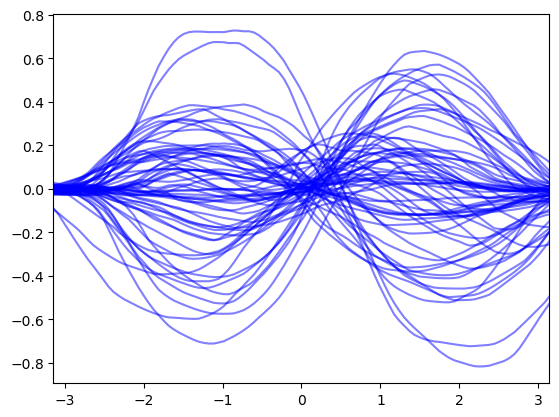

In [26]:
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))
    #xz = torch.cat((x_context, z_context), dim=2).to(device).float()
    py = anp.decoder(x_target.to(device), z_sample.to(device))

    mu = py.mean
    plt.plot(x_target.cpu().numpy()[0], mu.detach().cpu().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-pi, pi)

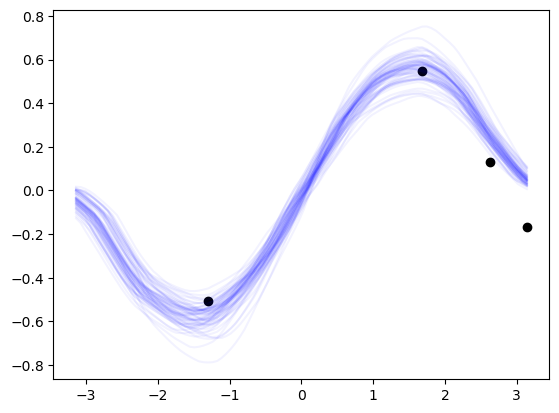

In [43]:
from src.utils import context_target_split

# Extract a batch from data_loader
for batch in data_loader:
    break

# Use batch to create random set of context points
x, y = batch
x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)

# Create a set of target points corresponding to entire [-pi, pi] range
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

x_context = x_context.to(device)
y_context = y_context.to(device)
x_target = x_target.to(device)

anp.training = False

for i in range(64):
    # Neural process returns distribution over y_target
    p_y_pred = anp(x_context, y_context, None, x_target)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    plt.plot(x_target.cpu().numpy()[0], mu.cpu().numpy()[0], 
                alpha=0.05, c='b')

plt.scatter(x_context[0].cpu().numpy(), y_context[0].cpu().numpy(), c='k')
plt.show()